In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in the data and take a quick peek

In [2]:
path=os.getcwd()+"\\data\\home_insurance.csv"
df_raw=pd.read_csv(path)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256136 entries, 0 to 256135
Data columns (total 66 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   QUOTE_DATE              129524 non-null  object 
 1   COVER_START             189021 non-null  object 
 2   CLAIM3YEARS             190039 non-null  object 
 3   P1_EMP_STATUS           189021 non-null  object 
 4   P1_PT_EMP_STATUS        1782 non-null    object 
 5   BUS_USE                 189021 non-null  object 
 6   CLERICAL                2944 non-null    object 
 7   AD_BUILDINGS            189021 non-null  object 
 8   RISK_RATED_AREA_B       140876 non-null  float64
 9   SUM_INSURED_BUILDINGS   189021 non-null  float64
 10  NCD_GRANTED_YEARS_B     189021 non-null  float64
 11  AD_CONTENTS             189021 non-null  object 
 12  RISK_RATED_AREA_C       180290 non-null  float64
 13  SUM_INSURED_CONTENTS    189021 non-null  float64
 14  NCD_GRANTED_YEARS_C 

### Investigate the target variable: there are several policies with no status

In [3]:
missing_status=len(df_raw[df_raw['POL_STATUS'].isnull()])/len(df_raw)
missing_status

0.26202876596807945

We remove missing_status policies from the dataset: they cannot be used to train the model

In [4]:
df_tgt_updated=df_raw[~df_raw['POL_STATUS'].isnull()].copy()
len(df_tgt_updated)

189021

We want to predict lapsed policies, so divide the target space into lapsed and non-lapsed

In [5]:
df_tgt_updated['POL_STATUS'].value_counts()

Live         132160
Lapsed        52534
Cancelled      4311
Unknown          16
Name: POL_STATUS, dtype: int64

In [6]:
df_tgt_updated['is_lapsed']=[1 if x == 'Lapsed' else 0 for x in df_tgt_updated['POL_STATUS']]
df_tgt_updated.drop('POL_STATUS', axis=1, inplace=True)

In [7]:
df_lapse_counts = df_tgt_updated.groupby('is_lapsed')['Police'].count().reset_index().rename(columns={'is_lapsed': 'lapse_index', 'Police': 'count'})
values=list(df_lapse_counts['count'].copy())
labels=['not_lapsed', 'lapsed']

Check the positive-negative ratio: are we dealing with unbalanced data?

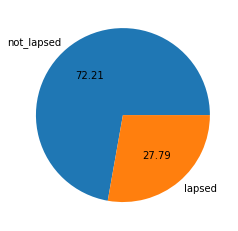

In [8]:
plt.figure()
plt.pie(values, labels=labels, autopct='%.2f')
plt.show()

### Turning to feature columns, remove those with > 10% missing values

In [9]:
min_values_count=int(0.9 * len(df_tgt_updated))
min_values_count

170118

In [10]:
values_count=[df_tgt_updated[col].count() for col in df_tgt_updated.columns]
list_cols_with_obs_count=list(filter(lambda x: x[1] < min_values_count, zip(df_tgt_updated.columns, values_count)))
list_cols_with_obs_count

[('QUOTE_DATE', 79144),
 ('P1_PT_EMP_STATUS', 1782),
 ('CLERICAL', 2944),
 ('RISK_RATED_AREA_B', 140876),
 ('CAMPAIGN_DESC', 0),
 ('PAYMENT_FREQUENCY', 80554),
 ('MTA_FAP', 55380),
 ('MTA_APRP', 55380),
 ('MTA_DATE', 26430)]

In [11]:
cols2drop=[val[0] for val in list_cols_with_obs_count]
cols2drop

['QUOTE_DATE',
 'P1_PT_EMP_STATUS',
 'CLERICAL',
 'RISK_RATED_AREA_B',
 'CAMPAIGN_DESC',
 'PAYMENT_FREQUENCY',
 'MTA_FAP',
 'MTA_APRP',
 'MTA_DATE']

In [12]:
df_updated=df_tgt_updated.drop(cols2drop, axis=1).copy()

#### List columns with missing values

In [13]:
values_count_updated=[df_updated[col].count() for col in df_updated.columns]
list_cols_with_missing_values=list(filter(lambda x: x[1] < len(df_updated), zip(df_updated.columns, values_count_updated)))
list_cols_with_missing_values

[('RISK_RATED_AREA_C', 180290)]

Peek into the missing values

In [14]:
pct_missing=1.0 - list_cols_with_missing_values[0][1]/len(df_updated)
round(pct_missing*100,0)

5.0

In [15]:
df_updated['RISK_RATED_AREA_C'].nunique()

49

<AxesSubplot:>

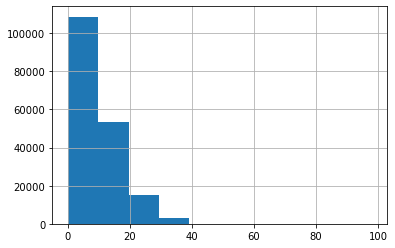

In [16]:
df_updated['RISK_RATED_AREA_C'].hist()

Do we impute missing values? Will return to this in the model-training phase. 

In [17]:
df_updated.columns

Index(['COVER_START', 'CLAIM3YEARS', 'P1_EMP_STATUS', 'BUS_USE',
       'AD_BUILDINGS', 'SUM_INSURED_BUILDINGS', 'NCD_GRANTED_YEARS_B',
       'AD_CONTENTS', 'RISK_RATED_AREA_C', 'SUM_INSURED_CONTENTS',
       'NCD_GRANTED_YEARS_C', 'CONTENTS_COVER', 'BUILDINGS_COVER',
       'SPEC_SUM_INSURED', 'SPEC_ITEM_PREM', 'UNSPEC_HRP_PREM', 'P1_DOB',
       'P1_MAR_STATUS', 'P1_POLICY_REFUSED', 'P1_SEX', 'APPR_ALARM',
       'APPR_LOCKS', 'BEDROOMS', 'ROOF_CONSTRUCTION', 'WALL_CONSTRUCTION',
       'FLOODING', 'LISTED', 'MAX_DAYS_UNOCC', 'NEIGH_WATCH', 'OCC_STATUS',
       'OWNERSHIP_TYPE', 'PAYING_GUESTS', 'PROP_TYPE', 'SAFE_INSTALLED',
       'SEC_DISC_REQ', 'SUBSIDENCE', 'YEARBUILT', 'PAYMENT_METHOD',
       'LEGAL_ADDON_PRE_REN', 'LEGAL_ADDON_POST_REN', 'HOME_EM_ADDON_PRE_REN',
       'HOME_EM_ADDON_POST_REN', 'GARDEN_ADDON_PRE_REN',
       'GARDEN_ADDON_POST_REN', 'KEYCARE_ADDON_PRE_REN',
       'KEYCARE_ADDON_POST_REN', 'HP1_ADDON_PRE_REN', 'HP1_ADDON_POST_REN',
       'HP2_ADDON_PRE_REN'

Write out the pre-processed data-set for exploratory data analysis

In [18]:
df_updated.set_index('is_lapsed').to_csv(os.getcwd()+"\\data\\home_insurance_processed.csv")